In [1]:
import pandas as pd
import polars as pl
import numpy as np
from openff.toolkit.topology import Molecule
from openff.units import unit
import seaborn as sb
from scipy import stats
import matplotlib.pyplot as plt
from rdkit.Chem import Draw
from rdkit import Chem
from chargecraft.storage.storage import MoleculePropStore

from scipy.stats import gaussian_kde
from matplotlib import cm
from matplotlib.colors import Normalize


def equalityline(x, y, ax = None, **kwargs):
    x0, x1 = min(x), max(x)
    y0, y1 = min(y), max(y)
    lims = [min(x0, y0), max(x1, y1)]
    ax = ax or plt.gca()
    ax.plot(lims, lims, **kwargs)

def m(x, y, ax = None, **kwargs):
    
    x = np.array(x)
    y = np.array(y)
    ax = ax or plt.gca()
    m =(np.sum((x - y)**2, axis=0)/(y.shape[0]))**0.5
    ax.annotate(f'$RMSE= {float(m):.2f}$',
                xy=(.01, .99), xycoords=ax.transAxes, fontsize=12,
                color='darkred', backgroundcolor='#FFFFFF99', ha='left', va='top')   
    
def kde(x, y, ax = None, **kwargs):

    if isinstance(x, np.ndarray) and isinstance(y, np.ndarray):
        x = np.array(x)
        y = np.array(y)
    ax = ax or plt.gca()
    kernel = stats.gaussian_kde(x)(y)
    ax.scatter(x, y, c=kernel, s=5)
    

def density_scatter_plot(x, y,ax=None, **kwargs):
    """
    :param x: data positions on the x axis
    :param y: data positions on the y axis
    :return: matplotlib.collections.PathCollection object
    """
    # Kernel Density Estimate (KDE)
    ax = ax or plt.gca()

    values = np.vstack((x, y))
    kernel = gaussian_kde(values)
    kde = kernel.evaluate(values)

    # create array with colors for each data point
    norm = Normalize(vmin=kde.min(), vmax=kde.max())
    colors = cm.ScalarMappable(norm=norm, cmap='viridis').to_rgba(kde)

    # override original color argument
    kwargs['color'] = colors

    return plt.scatter(x, y, **kwargs)


In [2]:
# df = pd.read_parquet('./charge_models_test_withgeoms.parquet')
pldf = pl.scan_parquet('./charge_models_test_withgeoms.parquet').collect(engine='streaming')
df = pldf.to_pandas()
df

mbis_charges  \
0      [-0.307478181466797, -0.32475236546718506, 0.0...   
1      [-0.27024134000385275, -0.2514930826279807, 0....   
2      [-0.22269026300546416, 0.0986548857271199, -0....   
3      [0.18318003045342993, -0.2598634431943842, -0....   
4      [-0.20271783777574814, 0.11143350543999422, -0...   
...                                                  ...   
34923  [-0.4307936125045173, 0.35266299719448524, -0....   
34924  [-0.316128375134428, -0.30531925078170524, 0.5...   
34925  [-0.446016524842485, 0.4470529110725375, -0.40...   
34926  [-0.3033673079675967, 0.126306495949047, -0.70...   
34927  [-0.35189626351936343, 0.17665521845659918, -0...   

                                          am1bcc_charges  \
0      [-0.1269, -0.1269, -0.111, -0.0814, 0.1528, -0...   
1      [-0.1094, -0.0984, 0.1401, -0.4256, 0.1264, 0....   
2      [-0.0894, 0.1548, -0.7962, 0.1548, -0.0894, -0...   
3      [0.1214, -0.0273, -0.3572, 0.1952, -0.3976, 0....   
4      [-0.0914, 0.1428, -0.7922, 0.1578, -0.138, 0.1...   
...                                                  ...   
34923  [-0.10315252631578949, 0.13044747368421053, -0...   
34924  [-0.08515876470588235, -0.2840587647058823, 0....   
34925  [-0.10454736842105264, 0.23015263157894736, -0...   
34926  [-0.11685454545454546, 0.15534545454545454, -0...   
34927  [-0.06690012, -0.022400119999999992, -0.213000...   

                                        espaloma_charges  \
0      [-0.17321058894906724, -0.17321058894906724, -...   
1      [-0.22874532377018647, -0.18081164097084718, 0...   
2      [-0.07576356260549455, 0.0697487351440248, -0....   
3      [0.10370072921117147, -0.2081667164961497, -0....   
4      [-0.12884797396040276, -0.012868405858937063, ...   
...                                                  ...   
34923  [-0.16938045071928123, 0.23442702544362923, -0...   
34924  [-0.11128084328682984, -0.2857638296178159, 0....   
34925  [-0.16086909488627785, 0.28039979620983724, -0...   
34926  [-0.15900079397992653, 0.0887342444197698, -0....   
34927  [-0.17873125702142714, -0.04560554951429367, -...   

                                       riniker_monopoles  \
0      [-0.3678119480609894, -0.37190431356430054, 0....   
1      [-0.31097567081451416, -0.3029680848121643, 0....   
2      [-0.30706286430358887, 0.01613098382949829, -0...   
3      [0.07321783900260925, -0.32436901330947876, -0...   
4      [-0.27458471059799194, 0.034048937261104584, -...   
...                                                  ...   
34923  [-0.5688874125480652, 0.35258910059928894, -0....   
34924  [-0.41569340229034424, -0.336565226316452, 0.4...   
34925  [-0.5875690579414368, 0.4356086552143097, -0.5...   
34926  [-0.35558021068573, 0.039914488792419434, -0.6...   
34927  [-0.4849037528038025, 0.20588380098342896, -0....   

                                            resp_charges  qm_dipoles  \
0      [-0.3026, -0.3026, 0.1671, -0.0841, 0.0157, -0...    0.463489   
1      [-0.1146, -0.0616, 0.4422, -0.553, 0.1441, 0.0...    0.424558   
2      [-0.055, 0.0874, -0.8195, 0.0874, -0.055, 0.10...    0.482231   
3      [-0.074, 0.0126, -0.2653, 0.0956, -0.3139, 0.0...    0.743610   
4      [-0.153, 0.2201, -0.809, 0.1195, 0.2035, 0.096...    1.166569   
...                                                  ...         ...   
34923  [-0.3234, 0.422, -0.3234, 0.0835, -0.1508, -0....    0.869328   
34924  [-0.2141, 0.1522, 0.4158, -0.4675, 0.4107, -0....    1.686318   
34925  [-0.3489, 0.6182, -0.3489, -0.2262, 0.0329, -0...    0.875990   
34926  [-0.1849, 0.2184, -0.8421, 0.2184, -0.1849, 0....    1.491349   
34927  [-0.2257, 0.1275, -0.508, -0.189, 0.1974, -0.4...    1.265903   

       mbis_dipoles  am1bcc_dipole  espaloma_dipole  riniker_dipoles  \
0          0.328383       0.411711         1.121593         0.320236   
1          0.453174       0.424885         0.729356         0.384860   
2          0.612847       0.657241         0.245546         0.616496   
3      

Compare the charge model dipoles with the QM dipoles

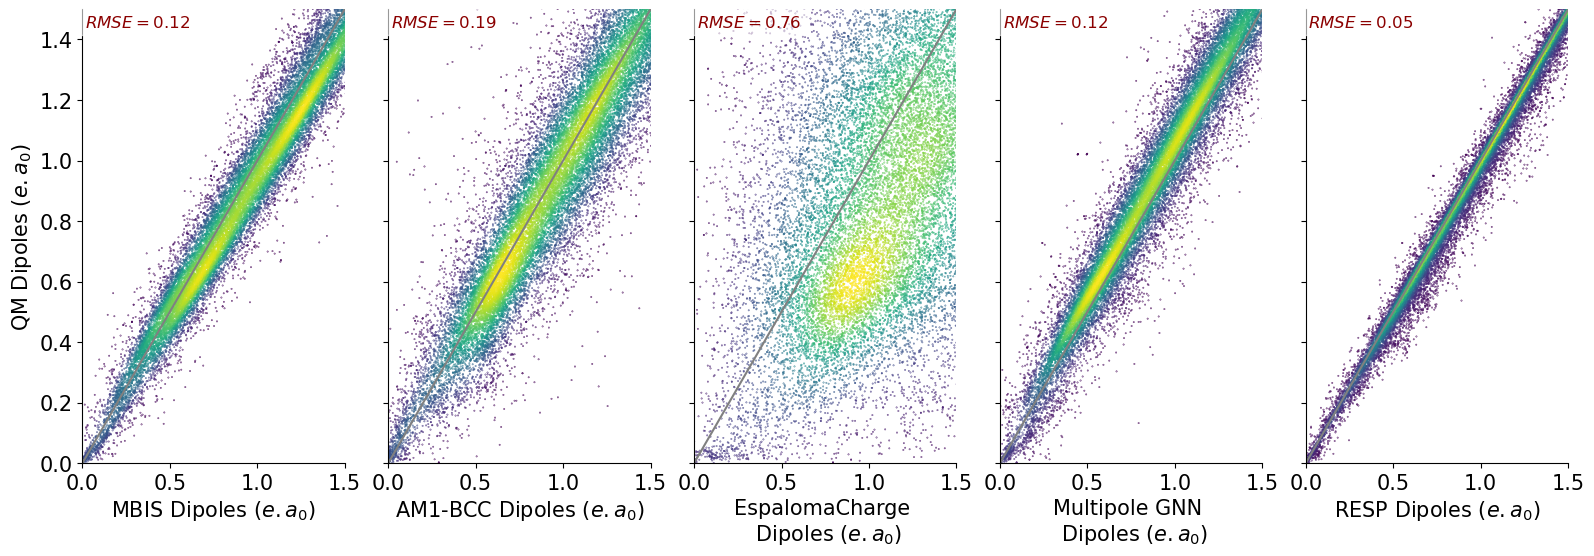

In [8]:
import matplotlib as mpl

mpl.rcParams['font.size'] = 15          # Base font size
mpl.rcParams['axes.labelsize'] = 15     # Axis label font size
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['xtick.labelsize'] =15
mpl.rcParams['ytick.labelsize'] = 15

width = 3.25  # inches (or 7.0)
height = 5.5
aspect = width / height

# Define the columns you want to compare against QM_HF_Dipoles
compare_columns = ['mbis_dipoles', 'am1bcc_dipole', 'espaloma_dipole', 'riniker_dipoles', 'resp_dipole']

# Initialize a PairGrid with col_wrap set to 3 for 3 columns per row
grid = sb.PairGrid(
    df, 
    x_vars=compare_columns, 
    y_vars=['qm_dipoles'], 
    height=height, 
    aspect=aspect
)

# Map the plots to the grid
grid = grid.map(density_scatter_plot, s=0.1)
grid = grid.map_offdiag(equalityline, color='gray', ls='-')
grid = grid.map_offdiag(m)
grid.map_diag(sb.kdeplot, color='gray')

# Set axis limits
grid.set(xlim=(0, 1.5), ylim=(0, 1.5))

label_dict = {
    "am1bcc_dipole": "AM1-BCC Dipoles ($e.a_{{0}}$)",
    "riniker_dipoles": "Multipole GNN \n Dipoles ($e.a_{{0}}$)",
    "resp_dipole": "RESP Dipoles ($e.a_{{0}}$)",
    "mbis_dipoles": "MBIS Dipoles ($e.a_{{0}}$)",
    "qm_dipoles": "QM Dipoles ($e.a_{{0}}$)",
    "espaloma_dipole": "EspalomaCharge \n Dipoles ($e.a_{{0}}$)"
}
    
# Manually set x-axis and y-axis labels
for i, ax in enumerate(grid.axes.flat):
    if i % len(compare_columns) == 0:  # y-axis label
        ax.set_ylabel(label_dict['qm_dipoles'], fontsize=15)
    if i < len(compare_columns):  # x-axis label
        ax.set_xlabel(label_dict[compare_columns[i % len(compare_columns)]], fontsize=15)

# Save and display the plot
plt.savefig('comparison_of_dipoles.png', bbox_inches= 'tight', dpi=300)
plt.show()


Compare the charge model ESPs with the QM ESPs 

['espaloma', 'am1bcc', 'mbis', 'riniker', 'resp']


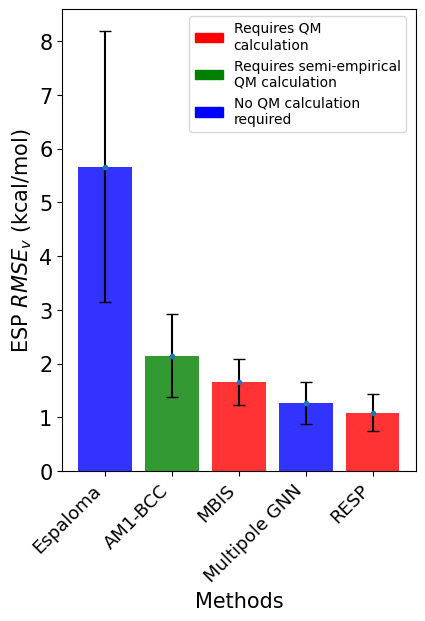

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define the columns to compare
compare_columns = ['am1bcc_esp_rms', 'espaloma_esp_rms', 'riniker_esp_rms', 'mbis_esp_rms', 'resp_esp_rms']

# Assign colors based on the requirements for each method
color_map = {
    'am1bcc_esp_rms': 'green',   # Semi-empirical QM calculation
    'espaloma_esp_rms': 'blue',  # No QM calculation required
    'riniker_esp_rms': 'blue',   # No QM calculation required
    'mbis_esp_rms': 'red',       # QM calculation required
    'resp_esp_rms': 'red'        # QM calculation required
}

# Calculate mean and standard deviation for the columns
mean_values = df[compare_columns].mean()
std_dev_values = df[compare_columns].std()

# Create a DataFrame for easy sorting and plotting
mean_values_df = pd.DataFrame({
    'mean': mean_values,
    'std_dev': std_dev_values,
    'color': [color_map[col] for col in compare_columns]  # Map colors to methods
}).sort_values(by='mean', ascending=False)

# Remove '_esp_rms' from the xtick labels
xtick_labels = [label.replace('_esp_rms', '') for label in mean_values_df.index]
print(xtick_labels)
width = 4.56

# Plot the bar chart with error bars
plt.figure(figsize=(width, 6))  # Adjust figure size as needed
plt.bar(
    x=xtick_labels,
    height=mean_values_df['mean'],
    color=mean_values_df['color'],  # Use the assigned colors
    alpha=0.8,
    label='Mean ESP RMSE'
)
plt.errorbar(
    x=xtick_labels,
    y=mean_values_df['mean'],
    yerr=mean_values_df['std_dev'],
    fmt=".", ecolor='black', capsize=4
)

label_mapping = {
    "am1bcc_esp_rms": "AM1-BCC",
    "espaloma_esp_rms": "Espaloma",
    "riniker_esp_rms": "Multipole GNN",
    "mbis_esp_rms": "MBIS",
    "resp_esp_rms": "RESP"
}
new_labels = [label_mapping[col] for col in mean_values_df.index]



# Add labels and formatting
plt.xticks(ticks=range(len(new_labels)), labels=new_labels,rotation=45, ha='right', fontsize=13)
plt.ylabel('ESP $RMSE_{v}$ (kcal/mol)', fontsize=15)
plt.xlabel('Methods', fontsize=15)
# plt.title('Comparison of ESP RMSE Values Across Methods', fontsize=14)

# Add a legend for context
red_patch = mpatches.Patch(color='red',
    label='Requires QM\ncalculation')
green_patch = mpatches.Patch(color='green',
    label='Requires semi-empirical\nQM calculation')
blue_patch = mpatches.Patch(color='blue',
    label='No QM calculation\nrequired')

plt.legend(
    handles=[red_patch, green_patch, blue_patch],
    bbox_to_anchor=(0.34, 1),  
    loc='upper left',           
    fontsize=10
)
# Save the figure or display it
plt.savefig('esp_comparison.png', dpi=800, bbox_inches='tight')
plt.show()


In [16]:
df_dipole_diff = abs(df['qm_dipoles'] - df['espaloma_dipole'])
sorted = df_dipole_diff.sort_values(ascending=False)
print(sorted.index)
df_sorted = df
df_sorted = df_sorted.reindex(sorted.index)
df_sorted 

Index([ 6122, 14287, 10858, 19039, 25677, 18556, 28316, 29297, 18530, 25941,
       ...
        3806,  1617, 16447,  6400, 31649, 30335,  5834,  4637, 23226,  5800],
      dtype='int64', length=34928)


mbis_charges  \
6122   [-0.24742223917632455, 0.09364282430804499, -0...   
14287  [-0.12467140438964196, -0.14129736159913048, -...   
10858  [-0.319129356638425, 0.08221165088988414, -0.5...   
19039  [-0.32948651802795764, 0.07137880901116261, -0...   
25677  [-0.11604277661047048, -0.2681888514639083, 0....   
...                                                  ...   
30335  [0.024529398952496846, 0.024529463896409615, -...   
5834   [-0.3241525528987955, -0.14534479246088824, -0...   
4637   [-0.3387297859041913, 0.11154820880221314, -0....   
23226  [0.24793772411967943, 0.1576938871746625, 0.15...   
5800   [-0.1328187552742078, -0.13289703807845935, -0...   

                                          am1bcc_charges  \
6122   [-0.21542499999999998, 0.232475, -0.354925, 0....   
14287  [-0.1219, -0.13340000000000002, -0.1074, -0.03...   
10858  [-0.1912, -0.0941, -0.1884, -0.021199999999999...   
19039  [-0.1833875, -0.0992875, -0.1915875, -0.042387...   
25677  [-0.11000000000000001, -0.11700000000000002, 0...   
...                                                  ...   
30335  [0.1128, 0.1128, -0.7962, 0.1128, 0.1128, -0.7...   
5834   [-0.09233076923076923, -0.08063076923076923, -...   
4637   [-0.08533529411764705, -0.06023529411764706, -...   
23226  [0.4069, 0.18, 0.18, 0.4069, -0.678, 0.6319, -...   
5800   [-0.13, -0.13, -0.13, -0.13, -0.13, -0.13, 0.1...   

                                        espaloma_charges  \
6122   [-0.2796502150595188, 0.29498427733778954, -0....   
14287  [-0.27838539853692057, -0.2699775077402592, -0...   
10858  [0.02985418267134163, 0.2712049508053396, -0.4...   
19039  [-0.01653145777527243, 0.26345587184187025, -0...   
25677  [-0.16277798880926436, -0.15655687322012252, 0...   
...                                                  ...   
30335  [0.048451216192916036, 0.04845119756646454, -0...   
5834   [-0.1297308708039614, -0.14230043240464652, -0...   
4637   [-0.17041340470314026, -0.13013671338558197, -...   
23226  [0.3084143815296037, 0.2489651409643037, 0.248...   
5800   [-0.21421746909618378, -0.21421746909618378, -...   

                                       riniker_monopoles  \
6122   [-0.259856641292572, 0.0287356898188591, -0.17...   
14287  [-0.1404235064983368, -0.13999103009700775, -0...   
10858  [-0.31682199239730835, 0.008154012262821198, -...   
19039  [-0.3265966773033142, -0.0031373798847198486, ...   
25677  [-0.13093028962612152, -0.2733839452266693, 0....   
...                                                  ...   
30335  [-0.06289201974868774, -0.06286685168743134, -...   
5834   [-0.438352108001709, -0.18077674508094788, -0....   
4637   [-0.47948431968688965, 0.21797099709510803, -0...   
23226  [0.17001131176948547, 0.1672910898923874, 0.16...   
5800   [-0.13805973529815674, -0.13812485337257385, -...   

                                            resp_charges    qm_dipoles  \
6122   [-0.193, 0.0044, -0.2106, 0.1478, -0.2975, 0.7...  9.290240e-01   
14287  [-0.188, -0.1222, -0.0845, -0.0823, -0.0845, -...  3.510981e-01   
10858  [-0.3778, -0.0954, -0.3342, 0.1041, 0.0923, 0....  3.012079e+00   
19039  [-0.415, -0.0858, -0.4172, 0.1601, 0.1967, -0....  2.093929e+00   
25677  [-0.1466, -0.3582, 0.3247, 0.4271, -0.4588, -0...  1.293184e+00   
...                                                  ...           ...   
30335  [0.0604, 0.0604, -0.7836, 0.0604, 0.0604, -0.7...  1.789965e-06   
5834   [-0.1365, 0.078, 0.0374, 0.0301, 0.0301, 0.037...  4.887878e-05   
4637   [-0.3586, 0.6709, -0.3586, -0.3586, -0.3586, 0...  5.024660e-07   
23226  [0.3638, 0.3031, 0.3031, 0.3638, -0.7442, 0.75...  1.315622e-06   
5800   [-0.135, -0.135, -0.135, -0.135, -0.135, -0.13...  2.574925e-08   

       mbis_dipoles  am1bcc_dipole  espaloma_dipole  riniker_dipoles  \
6122       1.095294   1.005214e+00     5.488524e+00         0.968911   
14287      0.273973   3.526513e-01     4.696850e+00         0.342851   
10858      3.087398   2.723225e+00     7.288254e+00    

Print out some example molecules 

O=C1CN=C(c2ccoc2)O1
C1=C(c2ccccc2)OCN1
N#Cc1cc(O)c2cc[nH]c2c1
Clc1cc2cc[nH]c2cc1Cl
N=Cc1ccc2c(c1)OCO2
Nc1nc(N)c2[nH]ccc2n1
N=C(N)NCCCc1c[nH]cn1
Cc1nc2c(s1)C(=O)C=CC2=O
Nc1nc(Cl)c2[nH]ccc2n1
OCc1c[nH]c2ccc(Cl)cc12


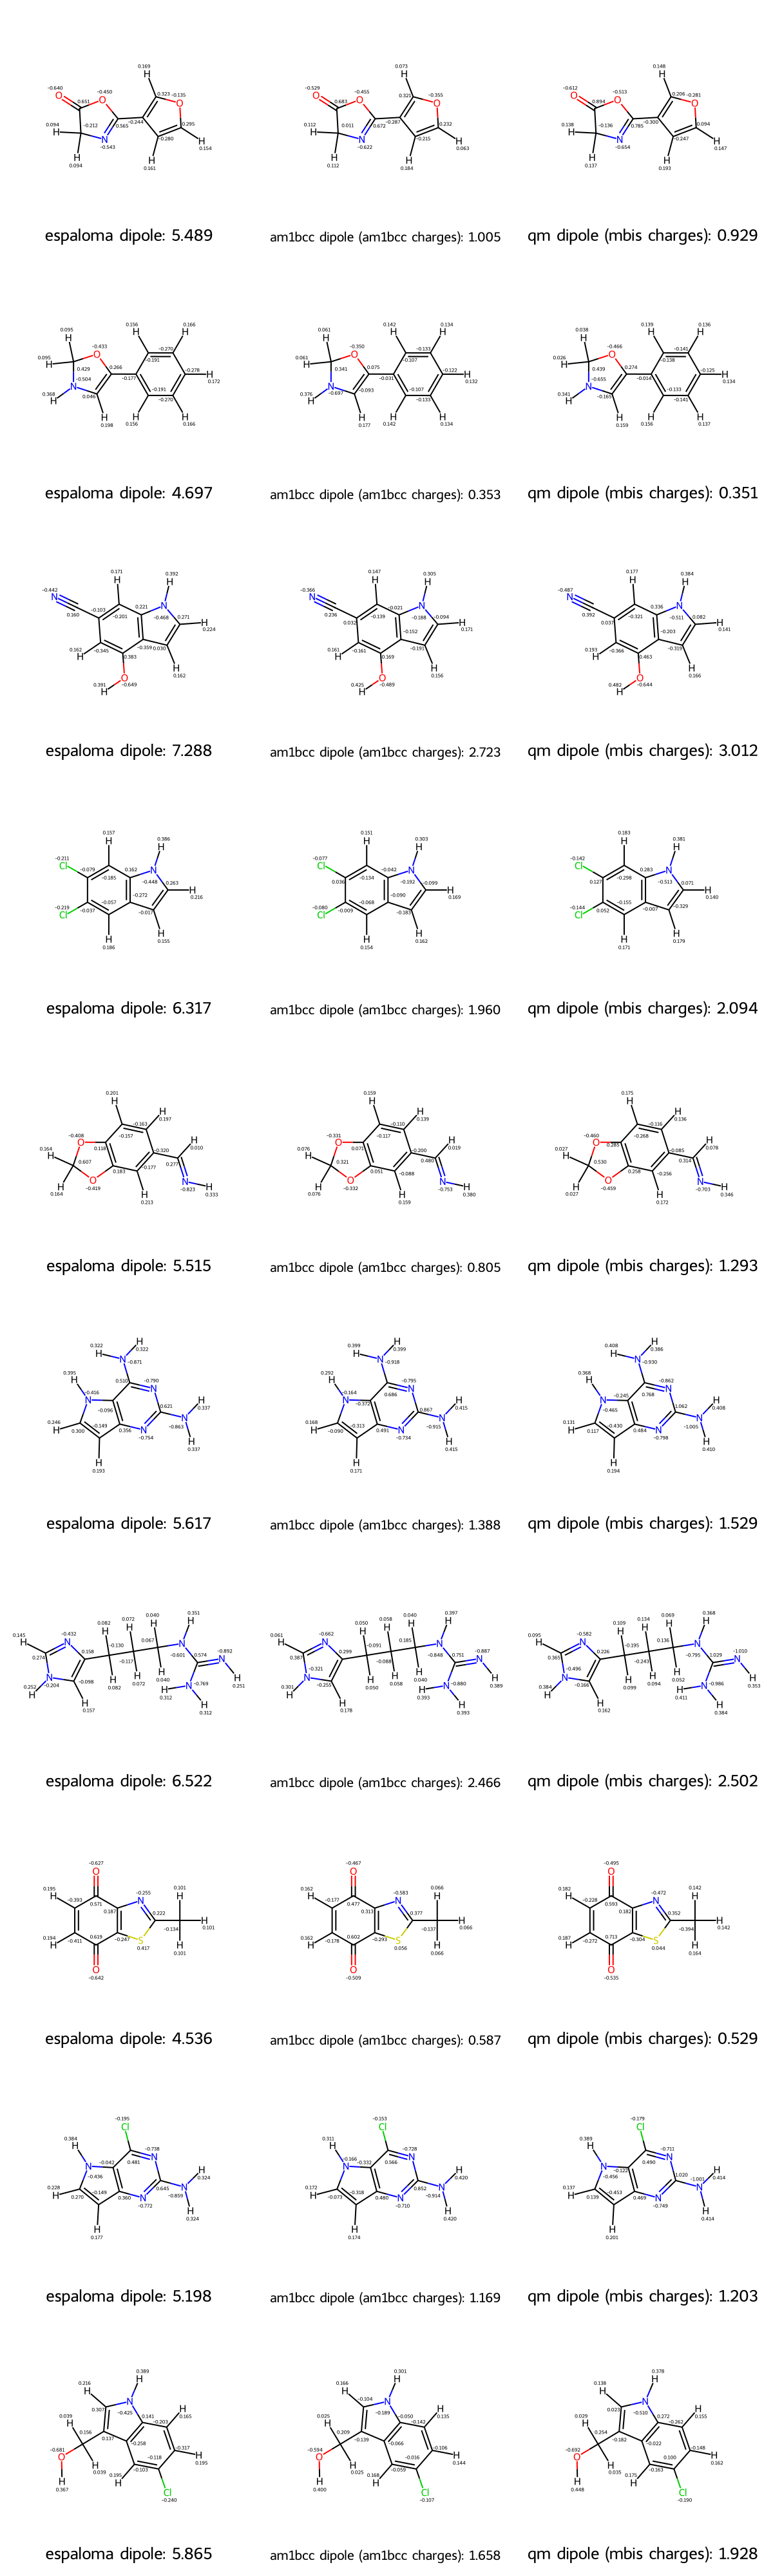

In [17]:
# now make the molecules
import itertools

investigate_this_num = 10

rdkit_mols = []
dipole_labels = []
#the worse offenders
for row in itertools.islice(df_sorted.iterrows(), investigate_this_num):
    row = row[-1]
    openff_mol = Molecule.from_mapped_smiles(row['molecule'], allow_undefined_stereo=True)
    print(openff_mol.to_smiles(explicit_hydrogens=False))
    rdkit_mol = openff_mol.to_rdkit()
    am1bcc_charges =  row['espaloma_charges']
    for i, atom in enumerate(rdkit_mol.GetAtoms()):
        lbl = '%.3f' % (am1bcc_charges[i])
        atom.SetProp('atomNote', lbl)
    rdkit_mols.append(rdkit_mol)
    dipole_labels.append(f"espaloma dipole: {'%.3f'% row['espaloma_dipole']}")

    rdkit_mol_am1bcc = openff_mol.to_rdkit()
    am1bcc_charges = row['am1bcc_charges']
    for i, atom in enumerate(rdkit_mol_am1bcc.GetAtoms()):
        lbl = '%.3f' % (am1bcc_charges[i])
        atom.SetProp('atomNote', lbl)
    rdkit_mols.append(rdkit_mol_am1bcc)
    dipole_labels.append(f"am1bcc dipole (am1bcc charges): {'%.3f'% row['am1bcc_dipole']} ")
    
    rdkit_mol_qm = openff_mol.to_rdkit()
    mbis_charges = row['mbis_charges']
    for i, atom in enumerate(rdkit_mol_qm.GetAtoms()):
        lbl = '%.3f' % (mbis_charges[i])
        atom.SetProp('atomNote', lbl)
    rdkit_mols.append(rdkit_mol_qm)
    dipole_labels.append(f"qm dipole (mbis charges): {'%.3f'% row['qm_dipoles']} ")
    
drawing_options = Draw.MolDrawOptions()
drawing_options.legendFontSize = 25     # Set the desired font size for legends

img = Draw.MolsToGridImage(rdkit_mols, subImgSize=(400, 400), legends=dipole_labels,molsPerRow=3,returnPNG=False, drawOptions=drawing_options)
img